In [ ]:
from google.colab import drive
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import nlpaug.augmenter.word as naw

drive.mount('/content/drive')
tar_gz_path = '/content/drive/My Drive/swmh.tar.gz'

def load_csv_from_tar(tar, file_path):
    for member in tar.getmembers():
        if file_path in member.name:
            file = tar.extractfile(member)
            return pd.read_csv(file)
    return None

with tarfile.open(tar_gz_path, 'r:gz') as tar:
    df_train = load_csv_from_tar(tar, 'swmh/train.csv')
    df_val = load_csv_from_tar(tar, 'swmh/val.csv')
    df_test = load_csv_from_tar(tar, 'swmh/test.csv')

Mounted at /content/drive


In [ ]:
le = LabelEncoder()
df_train['label'] = le.fit_transform(df_train['label'])
df_val['label'] = le.transform(df_val['label'])
df_test['label'] = le.transform(df_test['label'])

X_train, y_train = df_train['text'].values, df_train['label'].values
X_val, y_val = df_val['text'].values, df_val['label'].values
X_test, y_test = df_test['text'].values, df_test['label'].values

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [ ]:
aug = naw.SynonymAug(aug_src='wordnet')

In [ ]:
def augment_texts(texts, labels, augmenter, target_count):
    augmented_texts = list(texts)
    augmented_labels = list(labels)

    if len(augmented_texts) >= target_count:
        return augmented_texts[:target_count], augmented_labels[:target_count]

    num_samples = len(texts)
    iterations = (target_count - num_samples) // num_samples + 1

    print(f"Need {iterations} iterations to reach target count {target_count}")

    for i in range(iterations):
        print(f"Iteration {i+1}/{iterations}")
        for text, label in zip(texts, labels):
            if len(augmented_texts) < target_count:
                augmented_text = augmenter.augment(text)
                # Ensure the result is a single string and not a list
                if isinstance(augmented_text, list):
                    augmented_text = ' '.join(augmented_text)
                if isinstance(augmented_text, str) and len(augmented_text.strip()) > 0:
                    augmented_texts.append(augmented_text)
                    augmented_labels.append(label)
                else:
                    print(f"Skipping invalid augmentation result: {augmented_text}")
            if len(augmented_texts) >= target_count:
                break

    return augmented_texts[:target_count], augmented_labels[:target_count]

In [ ]:
unique_classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()

target_count = max_count

augmented_texts, augmented_labels = [], []

for cls in unique_classes:
    texts = X_train[y_train == cls]
    labels = y_train[y_train == cls]

    print(f"Class {cls} before augmentation: {len(texts)} samples")
    aug_texts, aug_labels = augment_texts(texts, labels, aug, target_count)
    print(f"Class {cls} after augmentation: {len(aug_texts)} samples")

    augmented_texts.extend(aug_texts)
    augmented_labels.extend(aug_labels)

unique_classes, counts = np.unique(augmented_labels, return_counts=True)
print("Number of samples per class after augmentation:")
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} samples")

Class 0 before augmentation: 6136 samples
Need 1 iterations to reach target count 11940
Iteration 1/1
Class 0 after augmentation: 11940 samples
Class 1 before augmentation: 6550 samples
Need 1 iterations to reach target count 11940
Iteration 1/1
Class 1 after augmentation: 11940 samples
Class 2 before augmentation: 4932 samples
Need 2 iterations to reach target count 11940
Iteration 1/2
Iteration 2/2
Class 2 after augmentation: 11940 samples
Class 3 before augmentation: 11940 samples
Class 3 after augmentation: 11940 samples
Class 4 before augmentation: 5265 samples
Need 2 iterations to reach target count 11940
Iteration 1/2
Iteration 2/2
Class 4 after augmentation: 11940 samples
Number of samples per class after augmentation:
Class 0: 11940 samples
Class 1: 11940 samples
Class 2: 11940 samples
Class 3: 11940 samples
Class 4: 11940 samples


In [ ]:
augmented_data = pd.DataFrame({'text': augmented_texts, 'label': augmented_labels})
augmented_data.to_csv('/content/drive/My Drive/augmented_data.csv', index=False)

In [ ]:
augmented_texts = [text for text in augmented_texts if isinstance(text, str) and len(text.strip()) > 0]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts, tokenizer, max_len=256):
    return tokenizer(
        list(texts),
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

encoded_train = encode_texts(augmented_texts, tokenizer)
encoded_val = encode_texts(X_val, tokenizer)
encoded_test = encode_texts(X_test, tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class TextDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

train_dataset = TextDataset(encoded_train['input_ids'], encoded_train['attention_mask'], torch.tensor(augmented_labels, dtype=torch.long))
val_dataset = TextDataset(encoded_val['input_ids'], encoded_val['attention_mask'], torch.tensor(y_val, dtype=torch.long))
test_dataset = TextDataset(encoded_test['input_ids'], encoded_test['attention_mask'], torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=16, sampler=RandomSampler(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=16, sampler=SequentialSampler(val_dataset))
test_loader = DataLoader(test_dataset, batch_size=16, sampler=SequentialSampler(test_dataset))

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
num_epochs = 3
total_steps = len(train_loader) * num_epochs
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss

            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_loss += loss.item()

    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

best_val_acc = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    print(f'Train loss {train_loss}, accuracy {train_acc}')
    val_acc, val_loss = eval_model(model, val_loader, device)
    print(f'Val loss {val_loss}, accuracy {val_acc}')

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_save_path = '/content/drive/My Drive/bert_best_model_.pth'
        torch.save(model.state_dict(), best_model_save_path)
        print(f'Best model saved to {best_model_save_path} with accuracy {best_val_acc}')

Epoch 1/3
Train loss 0.7257409323653703, accuracy 0.7283249581239531
Val loss 0.7991370317585972, accuracy 0.6969905812083621
Best model saved to /content/drive/My Drive/bert_best_model_.pth with accuracy 0.6969905812083621
Epoch 2/3
Train loss 0.4178923961415983, accuracy 0.8490619765494138
Val loss 0.8565928040294473, accuracy 0.7030783367792327
Best model saved to /content/drive/My Drive/bert_best_model_.pth with accuracy 0.7030783367792327
Epoch 3/3
Train loss 0.24069380592195455, accuracy 0.915745393634841
Val loss 0.9482546587192684, accuracy 0.7068688260969447
Best model saved to /content/drive/My Drive/bert_best_model_.pth with accuracy 0.7068688260969447


In [ ]:
best_model_load_path = '/content/drive/My Drive/bert_best_model_.pth'
model.load_state_dict(torch.load(best_model_load_path))
model.to(device)
print('Best model loaded successfully')

In [ ]:
def annotate_heatmap(data, percentages, ax, **kwargs):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            count = data[i, j]
            percentage = percentages[i, j]
            color = 'white' if data[i, j] > np.max(data) / 2 else 'black'
            ax.text(j + 0.5, i + 0.5, f'{count}\n{percentage:.2f}%', ha='center', va='center', color=color)

In [ ]:
y_test_pred = []
y_test_true = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        y_test_pred.extend(preds.cpu().numpy())
        y_test_true.extend(labels.cpu().numpy())

Test Set Evaluation
                   precision    recall  f1-score   support

     self.Anxiety       0.80      0.78      0.79      1911
self.SuicideWatch       0.64      0.66      0.65      2018
     self.bipolar       0.84      0.75      0.79      1493
  self.depression       0.64      0.70      0.67      3774
  self.offmychest       0.69      0.58      0.63      1687

         accuracy                           0.70     10883
        macro avg       0.72      0.70      0.71     10883
     weighted avg       0.70      0.70      0.70     10883



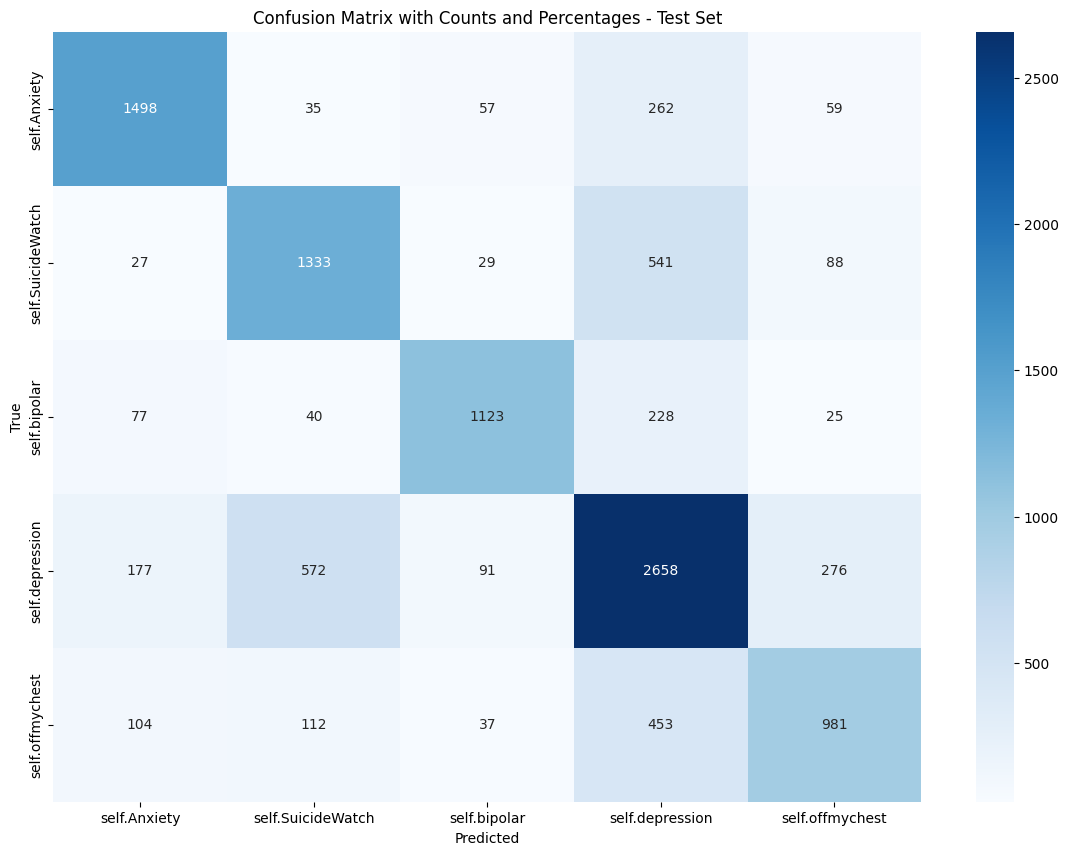

ROC-AUC for Test Set: 0.8073627388065026


In [ ]:
# Classification report for test set
print("Test Set Evaluation")
print(classification_report(y_test_true, y_test_pred, target_names=le.classes_))

# Confusion matrix for test set
conf_matrix_test = confusion_matrix(y_test_true, y_test_pred)
conf_matrix_test_percentage = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(14, 10))
ax = sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Counts and Percentages - Test Set')
plt.show()

roc_auc_test = roc_auc_score(y_test_true, pd.get_dummies(y_test_pred), multi_class='ovr')
print(f'ROC-AUC for Test Set: {roc_auc_test}')

In [ ]:
import csv
import torch.nn.functional as F

# Prepare data for CSV
csv_data = []
csv_data.append(["Text", "True Label", "Predicted Label", "Confidence"])

for i in range(len(X_test)):
    true_label = y_test[i]
    predicted_label = y_test_pred[i]
    true_label_name = le.inverse_transform([true_label])[0]
    predicted_label_name = le.inverse_transform([predicted_label])[0]

    input_ids = torch.tensor(encoded_test['input_ids'][i]).unsqueeze(0).to(device)
    attention_mask = torch.tensor(encoded_test['attention_mask'][i]).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        confidence = probs[0][predicted_label].item() * 100

    csv_data.append([X_test[i], true_label_name, predicted_label_name, f"{confidence:.2f}%"])

csv_file_path = "/content/drive/My Drive/test_predictions_.csv"
with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Test predictions saved to {csv_file_path}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-54-20a0f7ca5c58>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded_test['input_ids'][i]).unsqueeze(0).to(device)
<ipython-input-54-20a0f7ca5c58>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(encoded_test['attention_mask'][i]).unsqueeze(0).to(device)
<ipython-input-54-20a0f7ca5c58>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded_test['input_ids'][i]).unsqueeze(0).to(device)
<ipython-input-